## パッケージ導入

In [ ]:
!pip install --upgrade google-cloud-aiplatform japanize_matplotlib

In [ ]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## 事前準備

In [1]:
import os, json, datetime, pprint
import numpy as np

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

import vertexai
import vertexai.preview.generative_models as generative_models
from vertexai.preview.generative_models import GenerativeModel, Part
from vertexai.preview import caching

In [2]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
vertexai.init(project=PROJECT_ID, location='us-central1')

BUCKET = f'gs://{PROJECT_ID}-handson'

model_flash = GenerativeModel('gemini-1.5-flash')

In [3]:
def create_cached_model(movie_file, model_name='gemini-1.5-pro-001', ttl=60):
    prompt_cached = [
        '[movie file]',
        Part.from_uri(movie_file, mime_type='video/mp4'),
    ]
    cached_content = caching.CachedContent.create(
        model_name=model_name,
        contents=prompt_cached,
        ttl=datetime.timedelta(minutes=ttl)
    )
    model = GenerativeModel.from_cached_content(cached_content=cached_content)
    return model

In [4]:
def generate(prompt, model, temperature=0.4, top_p=0.4):
    responses = model.generate_content(
        prompt,
        generation_config={
            'max_output_tokens': 8192,
            'temperature': temperature,
            'top_p': top_p
        },
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=True,
    )

    result = ''
    for response in responses:  # API からの応答をストリーミングで画面表示
        try:
            print(response.text, end='')
            result += response.text
        except Exception as e:
            print(e)
            break

    return result               # 応答全体を返却

In [5]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

## 対象動画をキャッシング

In [6]:
!gsutil ls -l {BUCKET}/mp4/s*

  24857097  2025-01-10T04:28:47Z  gs://etsuji-movie-meta-handson/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4
   5514908  2025-01-10T04:28:45Z  gs://etsuji-movie-meta-handson/mp4/s_千葉県印西市にデータセンターを開設.mp4
  30815449  2025-01-10T04:28:48Z  gs://etsuji-movie-meta-handson/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4
TOTAL: 3 objects, 61187454 bytes (58.35 MiB)


In [7]:
target_s = f'{BUCKET}/mp4/s_千葉県印西市にデータセンターを開設.mp4'
model = create_cached_model(target_s, ttl=300)

# ファイル名の先頭が n_ の無音動画ファイルを指定すること
target_n = f'{BUCKET}/mp4/n_千葉県印西市にデータセンターを開設.mp4'
model_noaudio = create_cached_model(target_n, ttl=300)

**注意**

次のコマンドを実行するとプロジェクト内でキャッシュ中のデータをすべて削除できます。

キャッシュ中のデータに対する不要な課金を避けるために、検証が完了したら実行しておくことをお勧めします。

```
for item in caching.CachedContent.list():
    cached_content = caching.CachedContent(
        f'projects/{item.project}/locations/{item.location}/cachedContents/{item.name}')
    cached_content.delete()
```

In [8]:
filename = target_s.split('/')[-1]
basename = filename.rstrip('.mp4').lstrip('s_')
image_dir = f'{BUCKET}/image/{basename}'
gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
local_image_dir = basename

In [ ]:
# 静止画像ファイルをローカルにコピー
!gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

## キャラクター抽出

In [10]:
prompt_identify_characters = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find characters in the movie and describe the visual appearance of each character as detailed as possible.
B. Identify the name of each character you found on task A. If you cannot identify the name, name it "Unknown".
C. Identify representative scenes for each character where the character visually appears on the screen.

[condition]
B. The description has more than three sentences.
C. The number of scenes for each character is at most three. Each scene is identified with timestamp mm:ss-mm:ss.

[format instruction]
In Japanese. Output is a JSON list of "character dict". "character dict" is a JSON dict in the following format:
{
  "Character ID": <Sequential number starting from 1>,
  "Name": "<Character name>",
  "Visual Description": "<Visual appearance>",
  "Scenes": [ "<list of timestamp of representative scenes>" ]
}
'''

In [11]:
result = generate(prompt_identify_characters, model=model)

[
  {
    "Character ID": 1,
    "Name": "金井 匡彦",
    "Visual Description": "黒髪で短髪の男性。50代くらい。白いTシャツを着ており、胸元に青と白の波の模様と「Drive」という文字がプリントされている。Googleのデータセンターの前に立っている。",
    "Scenes": [
      "00:00-00:07",
      "00:07-00:29",
      "00:31-00:36"
    ]
  },
  {
    "Character ID": 2,
    "Name": "Unknown",
    "Visual Description": "黒髪を後ろで束ねた女性。30代くらい。白いブラウスの上に黒のカーディガンを着ており、ベージュのロングスカートを履いている。Googleのデータセンターの前に立っている。",
    "Scenes": [
      "00:36-01:25"
    ]
  },
  {
    "Character ID": 3,
    "Name": "高橋 駿",
    "Visual Description": "黒と赤に染め分けられた短髪の男性。20代くらい。Google Cloudのロゴが入った黒のTシャツを着ている。会議室のような部屋に座っている。",
    "Scenes": [
      "01:26-01:50"
    ]
  },
  {
    "Character ID": 4,
    "Name": "レオ キャラモン",
    "Visual Description": "黒髪で短髪で髭を生やした男性。40代くらい。黒のポロシャツを着ており、胸元に「CORM」というロゴが入っている。Googleのオフィスの回転ドアの前に立っている。眼鏡をかけている。",
    "Scenes": [
      "01:50-02:14"
    ]
  }
]

=====
1 金井 匡彦 黒髪で短髪の男性。50代くらい。白いTシャツを着ており、胸元に青と白の波の模様と「Drive」という文字がプリントされている。Googleのデータセンターの前に立っている。


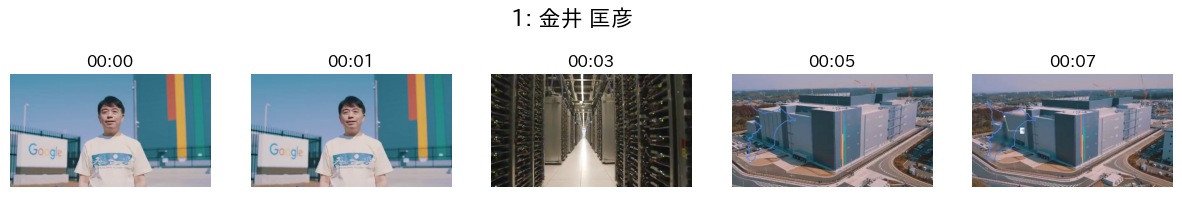

<Figure size 640x480 with 0 Axes>

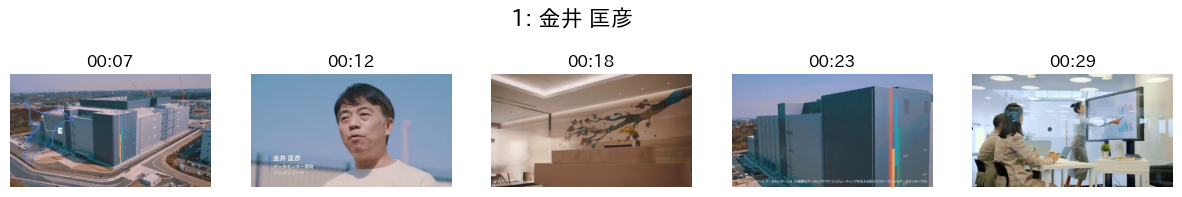

<Figure size 640x480 with 0 Axes>

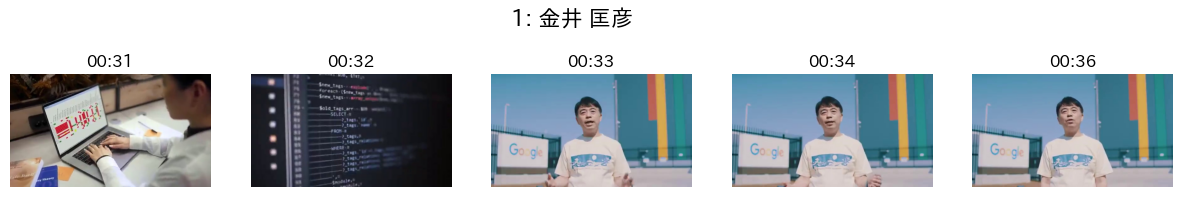

=====
2 Unknown 黒髪を後ろで束ねた女性。30代くらい。白いブラウスの上に黒のカーディガンを着ており、ベージュのロングスカートを履いている。Googleのデータセンターの前に立っている。


<Figure size 640x480 with 0 Axes>

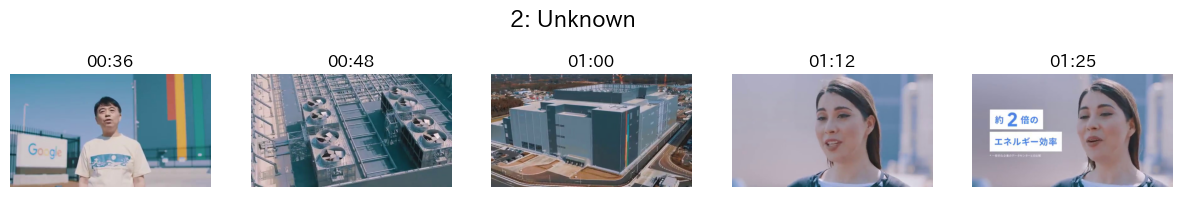

=====
3 高橋 駿 黒と赤に染め分けられた短髪の男性。20代くらい。Google Cloudのロゴが入った黒のTシャツを着ている。会議室のような部屋に座っている。


<Figure size 640x480 with 0 Axes>

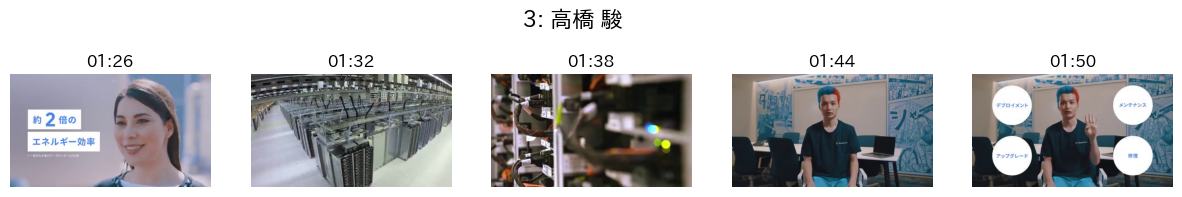

=====
4 レオ キャラモン 黒髪で短髪で髭を生やした男性。40代くらい。黒のポロシャツを着ており、胸元に「CORM」というロゴが入っている。Googleのオフィスの回転ドアの前に立っている。眼鏡をかけている。


<Figure size 640x480 with 0 Axes>

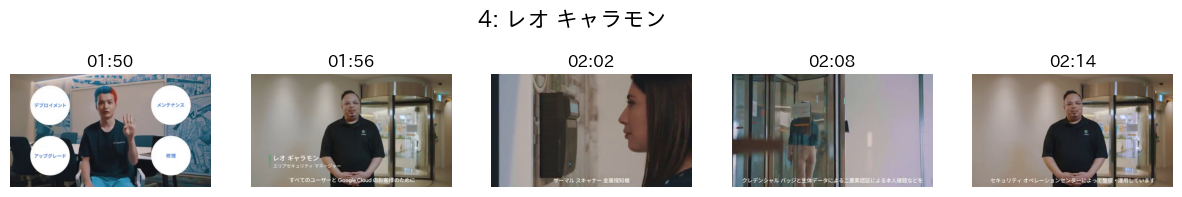

<Figure size 640x480 with 0 Axes>

In [12]:
scenes = load_json(result)
jpg_files = !ls "{local_image_dir}/"
m = 0
for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
    try:
        m = max(m, int(c))
    except:
        pass

for item in scenes:
    print('=====')
    print(item['Character ID'], item['Name'], item['Visual Description'])
    for ts in item['Scenes'][:3]:
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))  # Adjust figsize as needed
        axs = axs.ravel()
        fig.suptitle(str(item['Character ID']) + ': ' + item['Name'], fontsize=16)
        for c, ts in enumerate(np.linspace(max(1, ss1), min(ss2, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

キャラクター名はハルシネーションが起きている可能性があるので、外見の記述と参考画像を元にネット検索で正しい名前を検索して、参照用画像ファイルを別途用意

In [13]:
chars = !gsutil ls "{image_dir}/characters/*.png"
chars

['gs://etsuji-movie-meta-handson/image/千葉県印西市にデータセンターを開設/characters/ルイーズ イヴァノフ.png',
 'gs://etsuji-movie-meta-handson/image/千葉県印西市にデータセンターを開設/characters/レオ ギャラモン.png',
 'gs://etsuji-movie-meta-handson/image/千葉県印西市にデータセンターを開設/characters/金井 匡彦.png',
 'gs://etsuji-movie-meta-handson/image/千葉県印西市にデータセンターを開設/characters/高橋 駿.png']

In [14]:
prompt_reference = [
    '\n[Reference information to identify character names]'
]
image_files = {}
for item in chars:
    name = item.split('/')[-1].rstrip('.png')
    image_files[name] = item
    prompt_reference += [
        f'The name of following character is "{name}"',
        Part.from_uri(uri=image_files[name], mime_type='image/png')
    ]

prompt_reference

['\n[Reference information to identify character names]',
 'The name of following character is "ルイーズ イヴァノフ"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://etsuji-movie-meta-handson/image/\345\215\203\350\221\211\347\234\214\345\215\260\350\245\277\345\270\202\343\201\253\343\203\206\343\202\231\343\203\274\343\202\277\343\202\273\343\203\263\343\202\277\343\203\274\343\202\222\351\226\213\350\250\255/characters/\343\203\253\343\202\244\343\203\274\343\202\271\343\202\231 \343\202\244\343\202\246\343\202\231\343\202\241\343\203\216\343\203\225.png"
 },
 'The name of following character is "レオ ギャラモン"',
 file_data {
   mime_type: "image/png"
   file_uri: "gs://etsuji-movie-meta-handson/image/\345\215\203\350\221\211\347\234\214\345\215\260\350\245\277\345\270\202\343\201\253\343\203\206\343\202\231\343\203\274\343\202\277\343\202\273\343\203\263\343\202\277\343\203\274\343\202\222\351\226\213\350\250\255/characters/\343\203\254\343\202\252 \343\202\255\343\202\231\343\203\

## 動画サマリー

In [15]:
prompt_summary = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Give an one sentence summary of the movie that can be used as a title of the movie.
B. Summarize the content of the movie in five to ten sentences.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
A, B. The output should be based on the objective information in the movie.

[format instruction]
In Japanese. In the JSON dict with the following format:
{
  "Title": "<Output of Task A>",
  "Summary": "<Output of Task B>"
}
'''

prompt_summary = [prompt_summary] + prompt_reference

In [16]:
result = generate(prompt_summary, model=model)

{
  "Title": "千葉県印西市に開設された Google 最大規模のデータセンター",
  "Summary": "2023年、Google は千葉県印西市に日本最大規模のハイパースケールデータセンターを開設しました。\nデータセンター建設 ジャパンリードの金井 匡彦 氏によると、このデータセンターは Google データセンターのグローバル設計基準と日本独自技術・文化の融合によって設計されており、環境にも配慮されています。\nこのデータセンターによって、日本の企業は Google Cloud を含む Google 製品をより快適かつ安全に利用できるようになります。\nビルディングプログラムマネージャーのルイーズ イヴァノフ 氏によると、データセンターでは重要なインフラの運用維持を 24 時間 365 日行なっており、高いパフォーマンスを維持するために電力や冷却システムの継続的な供給が不可欠です。\nまた、インフラを効率的に運用していることも特徴で、一般的な企業のデータセンターと比較して約 2 倍のエネルギー効率を誇ります。\nデータセンター技術者の高橋 駿 氏によると、ハードウェア運用チームは何百万ものリグレッションテストをデータセンター内で実行し、高品質なパフォーマンスを実現しています。\nサーバーは無駄を省くために必要なコンポーネントのみを使用し、顧客にコストパフォーマンスの良いサービスを提供しています。\nまた、すべてのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行なっています。\nエリアセキュリティマネージャーのレオ ギャラモン 氏によると、すべてのユーザーと Google Cloud のお客様のために、データセンターは 6 層のセキュリティで保護されており、サーマルスキャナー、金属探知機、クレデンシャルバッジと生体データによる二要素認証による本人確認などを含みます。\nアクセス高速化と強固なセキュリティによる安定性と安全性、加えてサステナビリティへの配慮で、持続可能な経済活動を支えていきます。\n日本の顧客のビジネスとグローバルなデジタルエコノミーとの架け橋になること、それがこのデータセンターの大きな役割です。"
}

In [17]:
summary = pprint.pformat(load_json(result))

## 重要シーン抽出

In [18]:
prompt_important_scenes = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find around 15 important scenes in the movie with accurate timestamps.
B. Give a short summary of each scene and why that scene is important.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
The [summary] section contains the summary of the entire movie.
You don't need to use the summary information to find scenes, but the result should be consistent with the summary.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task B>
Header is: Timestamp, Description

[summary]
''' + summary

prompt_important_scenes = [prompt_important_scenes] + prompt_reference

In [19]:
important_scenes = generate(prompt_important_scenes, model=model)

Timestamp, Description
00:00-00:07, 金井 匡彦 氏が千葉県印西市に開設された Google のデータセンターを紹介するシーン。Google が 2023 年にデータセンターを開設したことが示され、場所が千葉県印西市であることが説明されています。
00:07-00:22, 金井 匡彦 氏がデータセンターの特徴を説明するシーン。データセンターは Google データセンターのグローバル設計基準と日本独自技術・文化の融合によって設計されており、環境にも配慮されていることが説明されています。また、日本最大規模のハイパースケールデータセンターであることも強調されています。
00:22-01:25, ルイーズ イヴァノフ 氏がデータセンターの運用維持について説明するシーン。データセンターでは重要なインフラの運用維持を 24 時間 365 日行なっており、高いパフォーマンスを維持するために電力や冷却システムの継続的な供給が不可欠であることが説明されています。また、インフラを効率的に運用していることも特徴で、一般的な企業のデータセンターと比較して約 2 倍のエネルギー効率を誇ることが説明されています。
01:25-01:50, 高橋 駿 氏がデータセンターのハードウェア運用について説明するシーン。ハードウェア運用チームは何百万ものリグレッションテストをデータセンター内で実行し、高品質なパフォーマンスを実現していること、サーバーは無駄を省くために必要なコンポーネントのみを使用し、顧客にコストパフォーマンスの良いサービスを提供していること、また、すべてのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行なっていることが説明されています。
01:50-02:14, レオ ギャラモン 氏がデータセンターのセキュリティについて説明するシーン。すべてのユーザーと Google Cloud のお客様のために、データセンターは 6 層のセキュリティで保護されており、サーマルスキャナー、金属探知機、クレデンシャルバッジと生体データによる二要素認証による本人確認などを含むことが説明されています。
02:14-02:35, 金井 匡彦 氏がデータセンターの役割について説明するシーン。アクセス高速化と強固なセキュリティによる安定性と安全性、加えて

## シーン情報（ビジュアル情報）取得

In [20]:
prompt_visuals = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Split the entire movie into scenes with accurate timestamps from start to the exact end of the movie file.
B. Describe what's happening in the scene as detailed as possible.
C. Enrich the output of task B by adding visual information of not only characters but also things in the background.

[condition]
A. The length of each scene is 1 to 15 seconds.
 - Good example: 00:05-00:08, 00:05-00:18. / Bad example: 00:05-01:14 as the timestamp jumps more than 15 seconds.
B, C. Avoid using audio information to describe the scene. Describle only what you see on the screen.
B. If possible, identify the names of characters. Use the full name on every part of the output.
C. The final description is very detailed, vivid and realistic to covey all the visual information of the scene, using up to three sentences.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task C>
Header is: Timestamp, Description
'''

prompt_visuals = [prompt_visuals] + prompt_reference

In [21]:
visual_info = generate(prompt_visuals, model=model)

Timestamp, Description
00:00-00:01, 金井 匡彦さんがGoogleのデータセンターの前に立っています。金井 匡彦さんは薄い黄色のTシャツを着ており、背景にはGoogleのロゴとカラフルな壁が見えます。金井 匡彦さんの背後には、フェンスと木々が見えます。
00:01-00:03, データセンターの内部の映像です。サーバーが整然と並んだ通路が映し出され、奥行きを感じさせる構図になっています。通路の両脇には、無数のサーバーラックが設置され、緑色のLEDライトが点滅しています。床は白く、清潔感が漂っています。
00:03-00:05, データセンターの外観を空撮した映像です。建物は巨大な長方形で、グレーの外壁にカラフルな縦線が描かれています。建物の周囲には、駐車場や緑地が広がり、奥には森林が見えます。
00:05-00:08, 金井 匡彦さんがGoogleのデータセンターの前に立っています。金井 匡彦さんは薄い黄色のTシャツを着ており、背景にはGoogleのロゴとカラフルな壁が見えます。金井 匡彦さんの背後には、フェンスと木々が見えます。
00:08-00:11, 金井 匡彦さんがGoogleのデータセンターの前に立って話しています。金井 匡彦さんは薄い黄色のTシャツを着ており、背景にはGoogleのロゴとカラフルな壁が見えます。金井 匡彦さんの背後には、フェンスと木々が見えます。
00:11-00:14, Googleのデータセンターのエントランスに男性が歩いて入っていく様子です。男性は黒いリュックを背負い、白い建物に向かって歩いています。建物のガラス張りの入り口には、Googleのロゴが大きく表示されています。
00:14-00:17, Googleのデータセンターの受付の様子です。木目調の壁に、カラフルな木の枝のアートが描かれています。受付カウンターは白く、その上に黄色い花が飾られています。カウンターの奥には、ガラス張りの部屋が見えます。
00:17-00:20, Googleのデータセンターの外観を空撮した映像です。建物は巨大な長方形で、グレーの外壁にカラフルな縦線が描かれています。建物の周囲には、駐車場や緑地が広がり、奥には森林が見えます。
00:20-00:22, Googleのデータセンターの屋上を空撮した映像です。屋上には、

## 音声文字起こし

In [22]:
prompt_transcription = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Transcript what they are speaking with accurate timestamps.

[condition]
A. Process the entire movie from start to the exact end of the movie file.
A. Identify the name of person who is speaking for each speech. Use the full name on every part of the output. If you cannot identify the name, name it "Unknown".

[format instruction]
In Japanese. Output is a JSON list of "speech dict". "speech dict" is a JSON dict in the following format:
{
  "timestamp": "<mm:ss-mm:ss>",
  "Name": "<Name of the speaker>",
  "Transcription": "<Transcription>"
}
'''

In [46]:
result = generate([prompt_transcription] + prompt_reference, model=model)

```json
[
  {
    "timestamp": "00:00-00:07",
    "Name": "金井 匡彦",
    "Transcription": "2023年 Googleとして データセンターを ここ 千葉県印西市に開設しました"
  },
  {
    "timestamp": "00:07-00:25",
    "Name": "金井 匡彦",
    "Transcription": "このデータセンターの特徴は 何と言っても Googleデータセンターのグローバル設計基準と 日本技術 文化の融合にて設計されていること そして日本で最大規模のハイパースケールデータセンターであることです 当然環境にも配慮した設計になっています このデータセンターによって 日本の企業の皆様が Google Cloudを含むGoogle製品を さらに快適に そして安全にお使いいただけるようになります"
  },
  {
    "timestamp": "00:36-01:25",
    "Name": "ルイーズ イヴァノフ",
    "Transcription": "データセンターでは 重要なインフラの運用維持を 24時間365日行っています 高いパフォーマンスを維持するために 電力や冷却システムの継続的な供給が必要不可欠です 地域の慣行や気候に沿ったGoogle基準のメンテナンスを実行することで 世界のGoogleデータセンターと同レベルの信頼性を実現しています また インフラを効率的に運用していることも このデータセンターの大きな特徴の1つです 全てのオペレーションが 環境に与える影響を最小限に抑える つまり より少ないエネルギーでの運用に 注力することで 一般的な企業のデータセンターと比較して 約2倍のエネルギー効率を誇ります"
  },
  {
    "timestamp": "01:26-01:50",
    "Name": "高橋 駿",
    "Transcription": "ハードウェア運用チームは 何百万ものリクエストをデータセンター内で実行し 高品質なパフォーマンスを実現しています サーバーは 無駄を省くために 必要なコンポーネントのみを使用し お客様に コストパフォーマンスの良いサービスを提供しています

In [48]:
transcription = pprint.pformat(load_json(result))

## テキスト情報取得

１回の処理ですべてのテキストを取得しようとすると、出力トークン数の上限に達するので、はじめにテキストが存在するシーンの情報を取得する。

In [50]:
prompt_text_layout = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Identify scenes where text strings are on the screen.
B. Describe the layout how text strings are arranged on the screen.

[conditions]
Process the entire movie from start to the exact end of the movie file.

[format instruction]
Layout description is in Japanese.
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Layout": "<layout description from Task B>"
}
'''

In [51]:
result = generate(prompt_text_layout, model=model_noaudio)

```json
[
  {
    "Timestamp": "00:06-00:08",
    "Layout": "画面左下にテキストを配置"
  },
  {
    "Timestamp": "00:08-00:10",
    "Layout": "画面左にテキストを縦書きで配置"
  },
  {
    "Timestamp": "00:20-00:21",
    "Layout": "画面下にテキストを配置"
  },
  {
    "Timestamp": "00:41-00:43",
    "Layout": "画面右に円形にテキストを配置、その左にテキストを縦書きで配置"
  },
  {
    "Timestamp": "01:22-01:24",
    "Layout": "画面右にテキストを配置、その下に小さいテキストを配置"
  },
  {
    "Timestamp": "01:27-01:29",
    "Layout": "画面左にテキストを縦書きで配置"
  },
  {
    "Timestamp": "01:44-01:49",
    "Layout": "画面中央にテキストを配置、その上下左右に円形にテキストを配置"
  },
  {
    "Timestamp": "01:51-01:54",
    "Layout": "画面左にテキストを縦書きで配置"
  },
  {
    "Timestamp": "01:55-01:59",
    "Layout": "画面下にテキストを配置"
  },
  {
    "Timestamp": "02:00-02:02",
    "Layout": "画面下にテキストを配置"
  },
  {
    "Timestamp": "02:03-02:07",
    "Layout": "画面下にテキストを配置"
  },
  {
    "Timestamp": "02:08-02:11",
    "Layout": "画面下にテキストを配置"
  },
  {
    "Timestamp": "02:12-02:13",
    "Layout": "画面下にテキストを配置"
  },
  {
    "Timestamp": "02:15

In [52]:
layout_info = load_json(result)

取得した情報から５シーンごとに分割してテキストを抽出する。

In [53]:
prompt_texts = '''\
You are a video content editor. Work on the following tasks.

[task]
A. The [text layout] contains scenes where text strings are on the screen in JSON list.
Extract exact text strings from each scene by repeating the [steps].

[steps]
1. Take the next "text dict" item from the [text layout].
2. Extract text strings from the scene specified by the "Timestamp" and "Layout".
3. Output the new "text dict" that have the "Text" element. "Timestamp" and "Layout" should be the same as the original item.

[condition]
A. Process the scenes only within the timestamps described in the [text layout]. Hence the "Timestamp" in the output should be the same as in the [text layout].
A. Output each character literally as on the screen. Don't modify them.
A. Use a list to store multiple lines of texts instead of using the return code \\n in the extracted text strings.
A. Make sure to use double quotes "" in the output JSON.

[format instruction]
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Text": [List of text strings from Task A>],
  "Layout": "<layout description>"
}

[text layout]
'''

In [54]:
merged_result = []
for c in range(0, len(layout_info), 5):
    print(f'\n=== Scene {c+1} to {c+5} ===')
    prompt = prompt_texts + pprint.pformat(layout_info[c:c+5])
    # 正しい JSON が出力されないなどで処理エラーが発生した場合は3回リトライする。
    n = 0
    while n < 3:
        try:
            result = generate(prompt, model=model_noaudio)    
            merged_result += load_json(result)
            break
        except Exception as e:
            print(e)
            n += 1
            pass
texts = pprint.pformat(merged_result)


=== Scene 1 to 5 ===
```json
[
  {
    "Timestamp": "00:06-00:08",
    "Text": [
      "千葉県 印西市"
    ],
    "Layout": "画面左下にテキストを配置"
  },
  {
    "Timestamp": "00:08-00:10",
    "Text": [
      "金井 匡彦",
      "データセンター建設",
      "ジャパンリード"
    ],
    "Layout": "画面左にテキストを縦書きで配置"
  },
  {
    "Timestamp": "00:20-00:21",
    "Text": [
      "※ハイパースケール データセンターとは、大規模なデータとクラウド コンピューティングを支える巨大でパワフルなデータセンターです。"
    ],
    "Layout": "画面下にテキストを配置"
  },
  {
    "Timestamp": "00:41-00:43",
    "Text": [
      "24H",
      "365DAY",
      "ルイス イグアシフ",
      "ビルディングプログラムマネージャー"
    ],
    "Layout": "画面右に円形にテキストを配置、その左にテキストを縦書きで配置"
  },
  {
    "Timestamp": "01:22-01:24",
    "Text": [
      "約2倍の",
      "エネルギー効率",
      "・一般的な企業のデータセンターとの比較"
    ],
    "Layout": "画面右にテキストを配置、その下に小さいテキストを配置"
  }
]
```
=== Scene 6 to 10 ===
```json
[
  {
    "Timestamp": "01:27-01:29",
    "Text": [
      "高橋\u3000駿",
      "データセンター技術者"
    ],
    "Layout": "画面左にテキストを縦書きで配置"
  },
  {
    "Timestamp": "01:44-01:49",
  

## テキストベースの動画内検索

In [55]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>",
  "Evidence": [<List of data snippets that support your result>]
}}

[user query]
{}

[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}
'''

In [56]:
def show_thumbnails(scenes):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2))  # Adjust figsize as needed
        axs = axs.ravel()
        print('=====')
        print(str(item['Description']))
        # 報告されたタイムスタンプの前後 3 秒を含めて 5 枚の静止画像を表示する
        for c, ts in enumerate(np.linspace(max(1, ss1-3), min(ss2+3, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [57]:
%%time
query = 'サーバーのメンテナンスについて解説しているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:07-00:25",
    "Description": "このシーンでは、金井 匡彦氏がデータセンターの特徴について説明しており、Google データセンターのグローバル設計基準と日本独自技術・文化の融合によって設計されていること、そして日本で最大規模のハイパースケールデータセンターであることが説明されています。サーバーのメンテナンスについて直接言及しているわけではありませんが、データセンターの設計や規模について説明していることから、サーバーのメンテナンスにも関連する情報が含まれていると考えられます。",
    "Evidence": [
      "{'Name': '金井 匡彦', 'Transcription': 'このデータセンターの特徴は 何と言っても Googleデータセンターのグローバル設計基準と 日本技術 文化の融合にて設計されていること そして日本で最大規模のハイパースケールデータセンターであることです 当然環境にも配慮した設計になっています このデータセンターによって 日本の企業の皆様が Google Cloudを含むGoogle製品を さらに快適に そして安全にお使いいただけるようになります', 'timestamp': '00:07-00:25'}"
    ]
  },
  {
    "Timestamp": "01:26-01:50",
    "Description": "このシーンでは、高橋 駿氏がデータセンターのハードウェア運用について説明しており、ハードウェア運用チームは何百万ものリグレッションテストをデータセンター内で実行し、高品質なパフォーマンスを実現していること、サーバーは無駄を省くために必要なコンポーネントのみを使用し、顧客にコストパフォーマンスの良いサービスを提供していること、また、すべてのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行なっていることが説明されています。サーバーのメンテナンスについて直接的に言及しているシーンです。",
    "Evidence": [
      "{'Name': '高橋 駿', 'Transcription': 'ハードウェア運用チームは 何百万ものリクエストをデータセンター内で

=====
このシーンでは、金井 匡彦氏がデータセンターの特徴について説明しており、Google データセンターのグローバル設計基準と日本独自技術・文化の融合によって設計されていること、そして日本で最大規模のハイパースケールデータセンターであることが説明されています。サーバーのメンテナンスについて直接言及しているわけではありませんが、データセンターの設計や規模について説明していることから、サーバーのメンテナンスにも関連する情報が含まれていると考えられます。


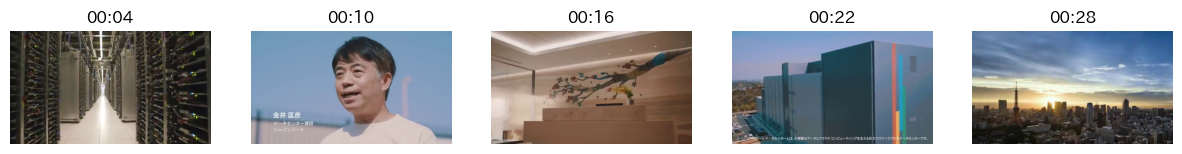

=====
このシーンでは、高橋 駿氏がデータセンターのハードウェア運用について説明しており、ハードウェア運用チームは何百万ものリグレッションテストをデータセンター内で実行し、高品質なパフォーマンスを実現していること、サーバーは無駄を省くために必要なコンポーネントのみを使用し、顧客にコストパフォーマンスの良いサービスを提供していること、また、すべてのハードウェアのデプロイメント、メンテナンス、アップグレード、修理も行なっていることが説明されています。サーバーのメンテナンスについて直接的に言及しているシーンです。


<Figure size 640x480 with 0 Axes>

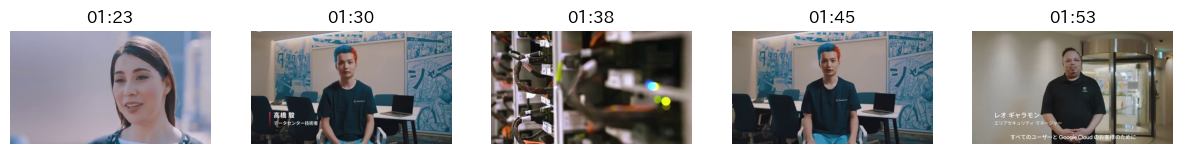

<Figure size 640x480 with 0 Axes>

In [58]:
show_thumbnails(load_json(result))

In [59]:
%%time
query = '金井さんが登場するシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:00-00:07",
    "Description": "このシーンでは、金井 匡彦さんがGoogleのデータセンターを紹介しており、データセンターが千葉県印西市に開設されたことがわかります。",
    "Evidence": [
      {
        "Transcription": "2023年 Googleとして データセンターを ここ 千葉県印西市に開設しました",
        "timestamp": "00:00-00:07"
      },
      {
        "Layout": "画面左下にテキストを配置",
        "Text": [
          "千葉県 印西市"
        ],
        "Timestamp": "00:06-00:08"
      }
    ]
  },
  {
    "Timestamp": "00:07-00:25",
    "Description": "このシーンでは、金井 匡彦さんがデータセンターの特徴について説明しており、データセンターがGoogleデータセンターのグローバル設計基準と日本独自技術・文化の融合によって設計されていること、そして日本で最大規模のハイパースケールデータセンターであることがわかります。",
    "Evidence": [
      {
        "Transcription": "このデータセンターの特徴は 何と言っても Googleデータセンターのグローバル設計基準と 日本技術 文化の融合にて設計されていること そして日本で最大規模のハイパースケールデータセンターであることです 当然環境にも配慮した設計になっています このデータセンターによって 日本の企業の皆様が Google Cloudを含むGoogle製品を さらに快適に そして安全にお使いいただけるようになります",
        "timestamp": "00:07-00:25"
      },
      {
        "Layout": "画面左にテキストを縦書きで配置",
        "Text": [
          "金井 匡彦",
       

=====
このシーンでは、金井 匡彦さんがGoogleのデータセンターを紹介しており、データセンターが千葉県印西市に開設されたことがわかります。


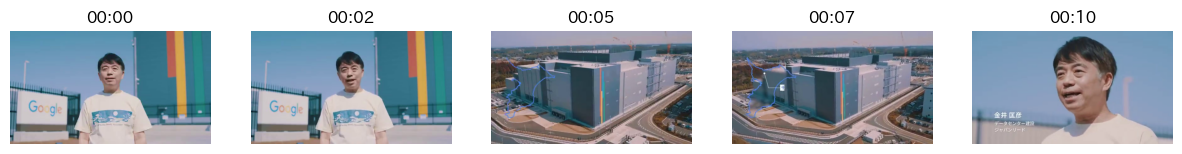

=====
このシーンでは、金井 匡彦さんがデータセンターの特徴について説明しており、データセンターがGoogleデータセンターのグローバル設計基準と日本独自技術・文化の融合によって設計されていること、そして日本で最大規模のハイパースケールデータセンターであることがわかります。


<Figure size 640x480 with 0 Axes>

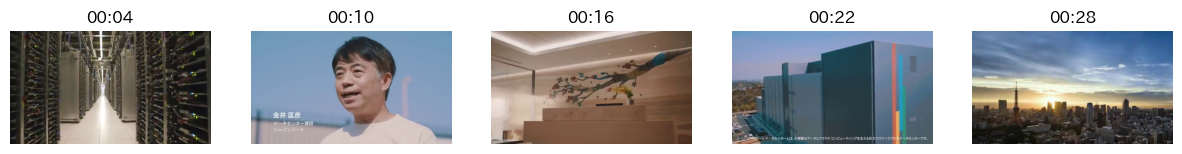

=====
このシーンでは、金井 匡彦さんがデータセンターの役割について説明しており、データセンターがアクセスの高速化と強固なセキュリティによる安定性と安全性、加えてサステナビリティへの配慮で持続可能な経済活動を支えていくこと、日本の顧客のビジネスとグローバルなデジタルエコノミーとの架け橋になることがわかります。


<Figure size 640x480 with 0 Axes>

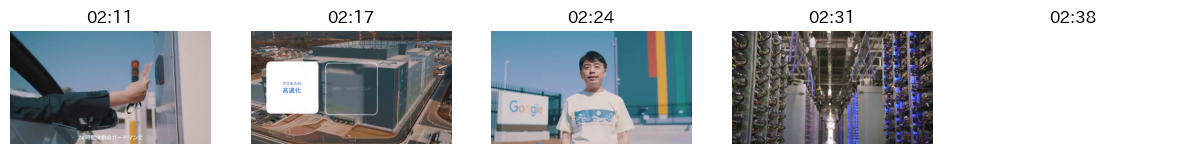

<Figure size 640x480 with 0 Axes>

In [60]:
show_thumbnails(load_json(result))

In [61]:
%%time
query = 'SNS投稿に適した映えるシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
result = generate(prompt, model=model_flash)

```json
[
  {
    "Timestamp": "00:00-00:07",
    "Description": "このシーンでは、Google のデータセンターが千葉県印西市に開設されたことが紹介されています。データセンターの外観が映し出され、Google のロゴも確認できます。SNS 投稿では、データセンターの壮大さをアピールするのに適しています。",
    "Evidence": [
      "{'Name': '金井 匡彦', 'Transcription': '2023年 Googleとして データセンターを ここ 千葉県印西市に開設しました', 'timestamp': '00:00-00:07'}",
      "00:00-00:01, 金井 匡彦さんがGoogleのデータセンターの前に立っています。金井 匡彦さんは薄い黄色のTシャツを着ており、背景にはGoogleのロゴとカラフルな壁が見えます。金井 匡彦さんの背後には、フェンスと木々が見えます。",
      "00:01-00:03, データセンターの内部の映像です。サーバーが整然と並んだ通路が映し出され、奥行きを感じさせる構図になっています。通路の両脇には、無数のサーバーラックが設置され、緑色のLEDライトが点滅しています。床は白く、清潔感が漂っています。",
      "00:03-00:05, データセンターの外観を空撮した映像です。建物は巨大な長方形で、グレーの外壁にカラフルな縦線が描かれています。建物の周囲には、駐車場や緑地が広がり、奥には森林が見えます。",
      "00:05-00:08, 金井 匡彦さんがGoogleのデータセンターの前に立っています。金井 匡彦さんは薄い黄色のTシャツを着ており、背景にはGoogleのロゴとカラフルな壁が見えます。金井 匡彦さんの背後には、フェンスと木々が見えます。"
    ]
  },
  {
    "Timestamp": "00:22-01:25",
    "Description": "このシーンでは、データセンターの運用維持について説明されています。特に、24 時間 365 日の運用体制や高いエネルギー効率が強調されています。データセンターの安定性と環境への配慮をアピールするのに適しています。",

=====
このシーンでは、Google のデータセンターが千葉県印西市に開設されたことが紹介されています。データセンターの外観が映し出され、Google のロゴも確認できます。SNS 投稿では、データセンターの壮大さをアピールするのに適しています。


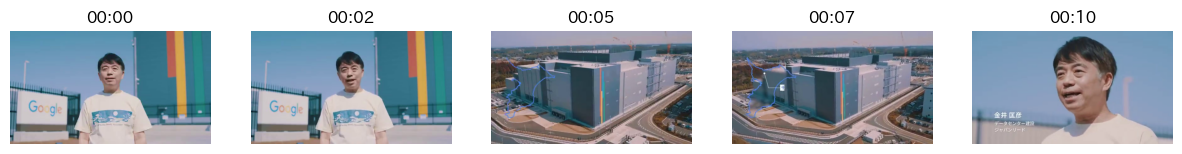

=====
このシーンでは、データセンターの運用維持について説明されています。特に、24 時間 365 日の運用体制や高いエネルギー効率が強調されています。データセンターの安定性と環境への配慮をアピールするのに適しています。


<Figure size 640x480 with 0 Axes>

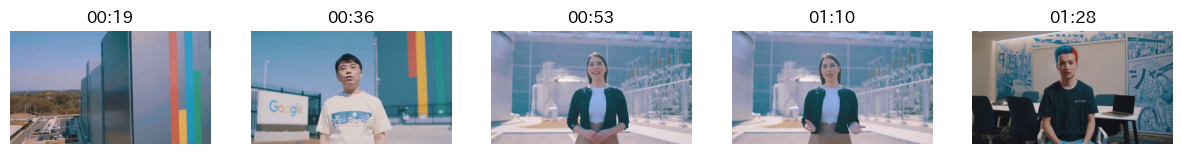

=====
このシーンでは、データセンターのセキュリティ対策について説明されています。6 層のセキュリティシステムや 24 時間体制の警備体制が紹介されています。データセンターの安全性と信頼性をアピールするのに適しています。


<Figure size 640x480 with 0 Axes>

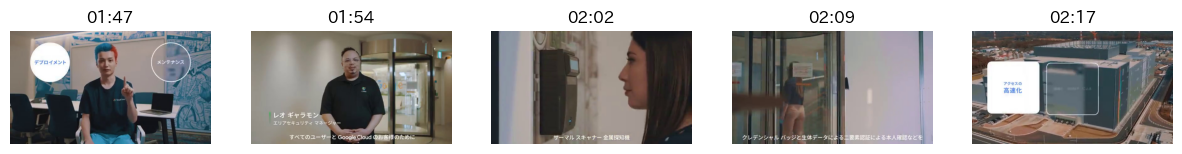

<Figure size 640x480 with 0 Axes>

In [62]:
show_thumbnails(load_json(result))

## 動画ベースの動画内検索

In [63]:
prompt_movie_content_search = '''\
You are a video content editor.
Find one to three scenes that matches the user query with timestamps.

[condition]
Try to identify names of characters.
The result should be based on the objective information in the movie itself.

[user query]
{}

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}
'''

In [72]:
%%time
query = 'サーバーのメンテナンスについて解説しているシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

```json
[
  {
    "Timestamp": "00:36-01:25",
    "Description": "ルイーズ イヴァノフがデータセンターのインフラの運用維持について説明しています。高いパフォーマンスを維持するために必要な電力や冷却システムの継続的な供給が必要不可欠であること、地域や基準に沿ったメンテナンスを実施していることを説明しています。"
  },
  {
    "Timestamp": "01:25-01:50",
    "Description": "高橋 駿がハードウェア運用チームの仕事内容について説明しています。数百万ものリグレッションテストをデータセンター内で実行し、高品質なパフォーマンスを実現していること、無駄を省くために必要なコンポーネントのみを使用し、コストパフォーマンスの良いサービスを提供していることを説明しています。"
  }
]
```CPU times: user 294 ms, sys: 110 ms, total: 404 ms
Wall time: 2min


=====
ルイーズ イヴァノフがデータセンターのインフラの運用維持について説明しています。高いパフォーマンスを維持するために必要な電力や冷却システムの継続的な供給が必要不可欠であること、地域や基準に沿ったメンテナンスを実施していることを説明しています。


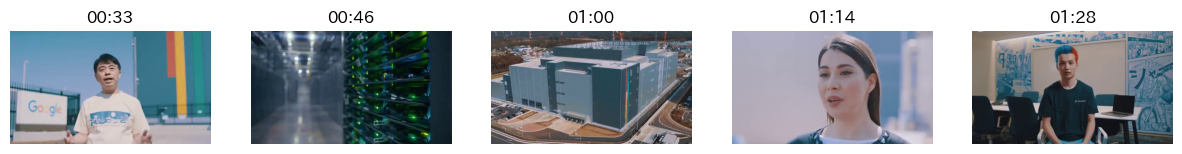

=====
高橋 駿がハードウェア運用チームの仕事内容について説明しています。数百万ものリグレッションテストをデータセンター内で実行し、高品質なパフォーマンスを実現していること、無駄を省くために必要なコンポーネントのみを使用し、コストパフォーマンスの良いサービスを提供していることを説明しています。


<Figure size 640x480 with 0 Axes>

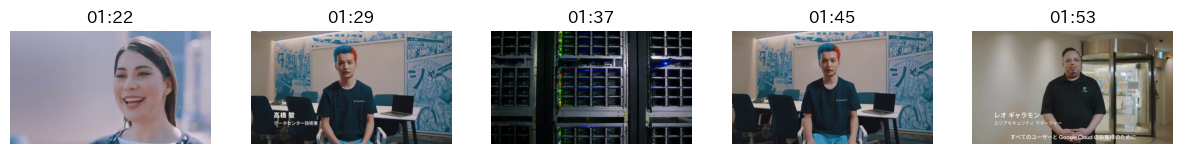

<Figure size 640x480 with 0 Axes>

In [73]:
show_thumbnails(load_json(result))

In [80]:
%%time
query = '金井さんが登場するシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

```json
[
  {
    "Timestamp": "00:00-00:08",
    "Description": "金井さんがGoogleのデータセンターについて説明しているシーンです。"
  },
  {
    "Timestamp": "00:08-00:36",
    "Description": "金井さんがデータセンターの特徴について説明しているシーンです。"
  },
  {
    "Timestamp": "02:21-02:35",
    "Description": "金井さんがデータセンターの役割について説明しているシーンです。"
  }
]
```CPU times: user 62.4 ms, sys: 20.4 ms, total: 82.8 ms
Wall time: 21.9 s


=====
金井さんがGoogleのデータセンターについて説明しているシーンです。


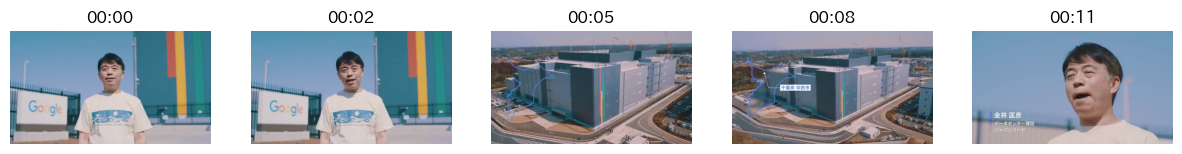

=====
金井さんがデータセンターの特徴について説明しているシーンです。


<Figure size 640x480 with 0 Axes>

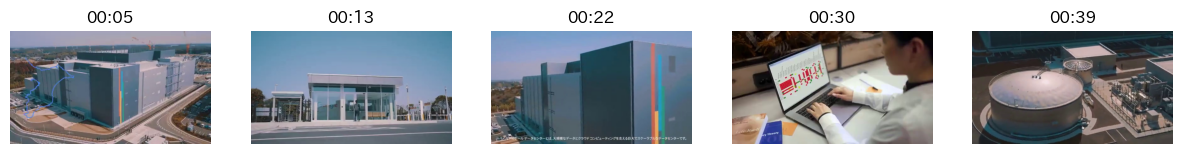

=====
金井さんがデータセンターの役割について説明しているシーンです。


<Figure size 640x480 with 0 Axes>

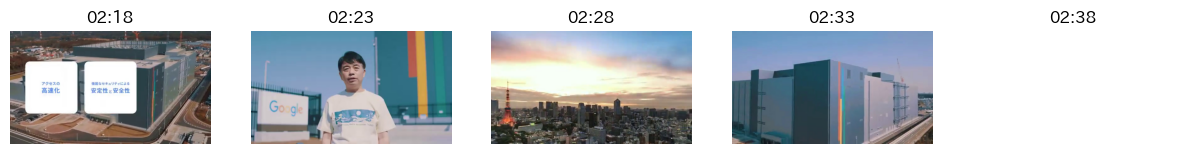

<Figure size 640x480 with 0 Axes>

In [81]:
show_thumbnails(load_json(result))

In [82]:
%%time
query = 'SNS投稿に適した映えるシーン'
prompt = prompt_movie_content_search.format(query)
prompt = [prompt] + prompt_reference
result = generate(prompt, model=model)

[
  {
    "Timestamp": "00:00-00:07",
    "Description": "Google データセンター建設 ジャパンリードの金井 匡彦さんが Google データセンターを紹介するシーンです。Google のロゴとデータセンターの外観が映えるシーンです。"
  },
  {
    "Timestamp": "01:25-01:30",
    "Description": "Google データセンターで働く社員が談笑しながら歩いているシーンと、データセンターのサーバー群が映えるシーンです。最先端で働く様子が伺えます。"
  },
  {
    "Timestamp": "01:49-01:58",
    "Description": "エリアセキュリティマネージャーのレオ ギャラモンさんがセキュリティについて説明しているシーンです。近未来的なセキュリティシステムが映えるシーンです。"
  }
]CPU times: user 106 ms, sys: 17.8 ms, total: 124 ms
Wall time: 37.7 s


=====
Google データセンター建設 ジャパンリードの金井 匡彦さんが Google データセンターを紹介するシーンです。Google のロゴとデータセンターの外観が映えるシーンです。


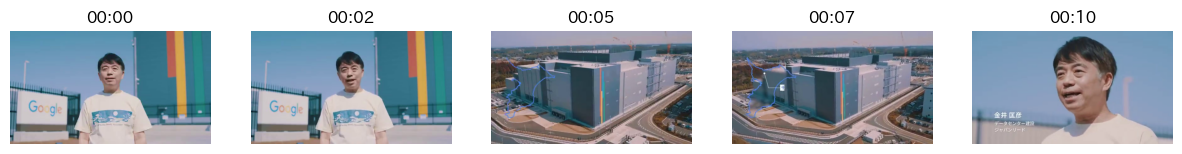

=====
Google データセンターで働く社員が談笑しながら歩いているシーンと、データセンターのサーバー群が映えるシーンです。最先端で働く様子が伺えます。


<Figure size 640x480 with 0 Axes>

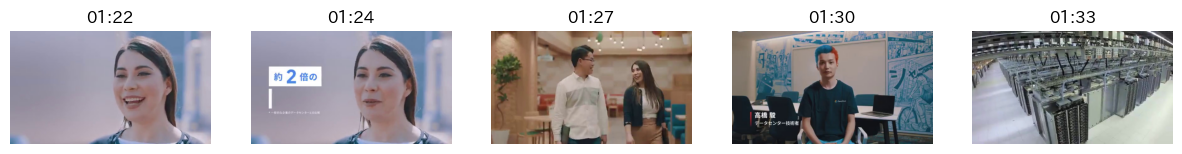

=====
エリアセキュリティマネージャーのレオ ギャラモンさんがセキュリティについて説明しているシーンです。近未来的なセキュリティシステムが映えるシーンです。


<Figure size 640x480 with 0 Axes>

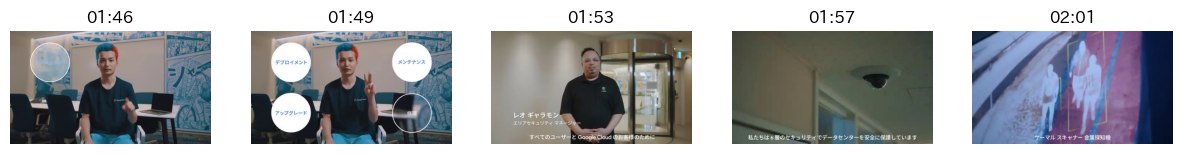

<Figure size 640x480 with 0 Axes>

In [83]:
show_thumbnails(load_json(result))

## 検索用メタテキストを保存

In [84]:
meta_text = '''\
[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}'''.format(summary, important_scenes, visual_info, transcription, texts)

metafile = f'{basename}.txt'
with open(metafile, 'w') as f:
    f.write(meta_text)

In [85]:
!gsutil cp "{metafile}" {BUCKET}/metadata/

Copying file://千葉県印西市にデータセンターを開設.txt [Content-Type=text/plain]...
/ [1 files][ 26.2 KiB/ 26.2 KiB]                                                
Operation completed over 1 objects/26.2 KiB.                                     
